In [1]:
import os

from matplotlib import pyplot as plt
import pandas as pd

In [2]:
prefix = '/home/tass/database/rutube_test/'

### Идеи

* повторяющиеся вопросы
  * сколько всего пользователей?
  * для какого количества пользователей один и тот же вопрос был задан несколько раз?
  * каково максимальное количество ответов на один и тот же вопрос?
  

# Повторяющиеся вопросы

In [3]:
personal_events = pd.read_csv(os.path.join(prefix, 'personal_events.csv'))

### всего пользователей

In [4]:
personal_events.user_id.unique().shape

(303934,)

### посчитать количество повторов вопросов для пользователя

In [5]:
choice_events = personal_events[personal_events.event_type == 'personal_choice']
count_repeated = choice_events.groupby(['user_id', 'interactive_id']).size().reset_index(name='count_occurences').sort_values(by='count_occurences', ascending=False)

In [7]:
count_repeated.head(n=1000)

,user_id,interactive_id,count_occurences
676909,6507866,188,370
676893,6507866,164,232
5024908,6723748,186,152
6556260,7054427,187,146
4871594,6711128,186,145
3647025,6631395,164,134
676863,6507866,92,127
3647038,6631395,188,126
6395591,6968769,188,125
6442212,6988097,187,117


#### Для какого количества пользователей у нас больше 16 повторений какого-то вопроса?

In [8]:
count_repeated[count_repeated.count_occurences > 16].user_id.unique().shape

(3678,)

In [10]:
3678 / 303934 * 100

1.2101311468937335

### Для 1.2% пользователей можно попробовать просто посмотреть, насколько часто пользователь даёт один и тот же ответ на один и тот же вопрос

### Наиболее часто повторно заданные вопросы:

In [12]:
interactive = pd.read_csv(os.path.join(prefix, 'interactive.tsv'), sep='\t')

In [13]:
interactive[(interactive.id == 188) | 
            (interactive.id == 187) | 
            (interactive.id == 186) | 
            (interactive.id == 164)]

,id,title
120,164,Смотрите ли Вы Дом-2. Город любви в 23:00 на к...
136,186,Хиты какого исполнителя есть в вашем плей-листе?
137,187,На что вы обращаете внимание при просмотре муз...
138,188,Для чего вы смотрите музыкальные телеканалы?


### Конкретный пользователь

In [14]:
def user_question_stat(user_id, question_id):
    return personal_events[(personal_events.user_id == user_id) & 
                    (personal_events.interactive_id == question_id) &
                    (personal_events.event_type == 'personal_choice')].groupby('interactive_item_id').size().reset_index(name='answers_freq')

In [15]:
user_question_stat(6507866, 188)

,interactive_item_id,answers_freq
0,800,59
1,801,122
2,802,98
3,803,91


In [16]:
user_question_stat(6507866, 164)

,interactive_item_id,answers_freq
0,699,86
1,700,42
2,701,52
3,702,52


In [17]:
user_question_stat(6723748, 186)

,interactive_item_id,answers_freq
0,788,16
1,789,12
2,790,27
3,791,26
4,792,19
5,793,28
6,794,24


### Ответы трёх пользователей выше похожи на равномерное протыкивание. Того, который ниже, похоже на попытки ответить честно

In [18]:
user_question_stat(6557515, 187)

,interactive_item_id,answers_freq
0,795,7
1,796,16
2,797,1
3,798,1


## Идея:

* Выбираем пользователей, для которых один вопрос был задан больше некоторого порогового количества раз (16)
* Накапливаем dict (user_id, interactive_id) -> (interactive_item_id, freq)
* В рамках пары (user_id, interactive_id) рассчитываем относительную дисперсию частот
* В рамках пользователя находим среднюю дисперсию частот ответов по вопросам, которые он задавал
* Строим гистограмму средний дисперсий частот ответов пользователей. Ожидаются два пика - большие величины для отвечающих честно и малые для равномерно тыкающих

In [19]:
users_rep_ids = count_repeated[count_repeated.count_occurences > 16].user_id.unique()
users_rep_ids.shape

(3678,)

In [20]:
selected_events = personal_events[personal_events.user_id.isin(users_rep_ids) & (personal_events.event_type == 'personal_choice')]
selected_events.shape

(549992, 6)

In [21]:
selected_events.head()

,created,event_type,user_id,creative_id,interactive_id,interactive_item_id
1,2019-06-16 21:00:53,personal_choice,6050757,16,109,464
11,2019-06-16 21:09:42,personal_choice,5740927,1,99,414
19,2019-06-16 21:12:55,personal_choice,6267620,1,98,408
37,2019-06-16 21:19:22,personal_choice,6046499,3,88,372
50,2019-06-16 21:26:26,personal_choice,5962529,31,79,340


In [22]:
user_question_answer_freq = selected_events.groupby(['user_id', 'interactive_id', 'interactive_item_id']).size().reset_index(name='answer_freq').sort_values(by='answer_freq', ascending=False)

In [23]:
user_question_answer_freq.head()

,user_id,interactive_id,interactive_item_id,answer_freq
57817,6507866,188,801,122
209252,6631395,188,803,109
252449,6741110,188,802,101
57818,6507866,188,802,98
57819,6507866,188,803,91


In [24]:
freq_acc = user_question_answer_freq.groupby(['user_id', 'interactive_id'], as_index=False).agg({'answer_freq': ['sum', 'std', 'mean']})
freq_acc.columns = ['_'.join(tt for tt in t if tt) for t in freq_acc.columns.ravel()]
freq_acc.dropna(inplace=True)

In [25]:
freq_acc['rel_std'] = freq_acc.answer_freq_std / freq_acc.answer_freq_mean

In [26]:
freq_acc.head()

,user_id,interactive_id,answer_freq_sum,answer_freq_std,answer_freq_mean,rel_std
0,18247,7,4,1.414214,2.000000,0.707107
1,18247,28,6,1.000000,1.500000,0.666667
4,18247,79,22,3.777124,3.666667,1.030125
8,18247,94,4,1.414214,2.000000,0.707107
13,18247,102,3,0.000000,1.000000,0.000000


In [27]:
stat_per_user = freq_acc.groupby('user_id', as_index=False).agg({'rel_std': ['mean']})
stat_per_user.columns = ['_'.join(tt for tt in t if tt) for t in stat_per_user.columns.ravel()]

In [28]:
stat_per_user.head()

,user_id,rel_std_mean
0,18247,0.391871
1,56582,0.497387
2,297859,0.690822
3,630521,0.399724
4,670989,0.000000


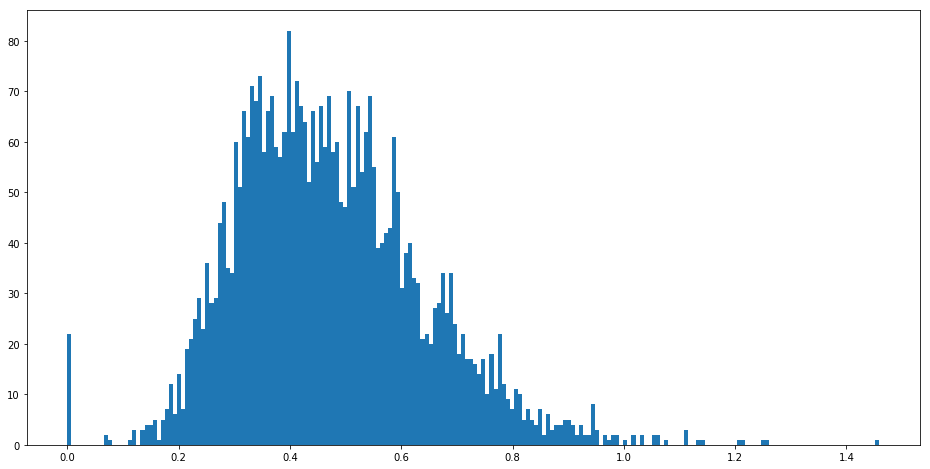

In [30]:
f = plt.figure(figsize=(16, 8))
plt.hist(stat_per_user.rel_std_mean, bins=200)
plt.show()
plt.close(f)

## Фиг два тут какие-то два пика. Но хоть посмотрим, похоже ли посчитанное число на фактор

In [31]:
stat_per_user[stat_per_user.rel_std_mean < 0.2].head()

,user_id,rel_std_mean
4,670989,0.000000
143,6233573,0.185903
149,6257930,0.196419
159,6278958,0.000000
200,6429002,0.188283


In [32]:
stat_per_user[stat_per_user.rel_std_mean > 0.8].head()

,user_id,rel_std_mean
27,2499405,0.903920
44,3878297,0.923274
63,5707761,0.933174
90,5972271,0.863907
91,5975794,0.814856


In [43]:
user_events = personal_events[(personal_events.user_id == 6233573)  & (personal_events.event_type == 'personal_choice')]
user_events.groupby(['user_id', 'interactive_id', 'interactive_item_id'], as_index=False).size().reset_index(name='ans_freq').sort_values(by=['interactive_id', 'interactive_item_id'])

,user_id,interactive_id,interactive_item_id,ans_freq
0,6233573,7,20,1
1,6233573,7,23,1
2,6233573,28,96,1
3,6233573,28,97,2
4,6233573,61,247,3
5,6233573,61,248,4
6,6233573,63,266,1
7,6233573,79,335,10
8,6233573,79,336,6
9,6233573,79,339,2


In [44]:
user_events = personal_events[(personal_events.user_id == 2499405) & (personal_events.event_type == 'personal_choice')]
user_events.groupby(['user_id', 'interactive_id', 'interactive_item_id'], as_index=False).size().reset_index(name='ans_freq').sort_values(by=['interactive_id', 'interactive_item_id'])

,user_id,interactive_id,interactive_item_id,ans_freq
0,2499405,7,22,1
1,2499405,7,23,3
2,2499405,28,99,2
3,2499405,38,140,1
4,2499405,61,248,1
5,2499405,63,250,1
6,2499405,64,258,1
7,2499405,79,339,6
8,2499405,79,340,1
9,2499405,80,344,1


## Не видно, чтобы средняя дисперсия частот ответов была хорошим фактором